# Problema CIFAR-10 (clasificación de objetos)


## Descripción

El conjunto de datos CIFAR-10 es un popular conjunto de datos utilizado en el campo del aprendizaje automático y la visión por computadora. Fue creado por Alex Krizhevsky, Vinod Nair y Geoffrey Hinton y es ampliamente utilizado como punto de referencia para probar algoritmos de clasificación de imágenes. CIFAR-10 consta de imágenes en color de tamaño 32x32 píxeles y se divide en 10 clases diferentes, cada una representando una categoría de objeto.

Las 10 clases en el conjunto de datos CIFAR-10 son:

- Avión
- Automóvil
- Pájaro
- Gato
- Ciervo
- Perro
- Rana
- Caballo
- Barco
- Camión

El conjunto de datos contiene un total de 60,000 imágenes de entrenamiento, distribuidas en 6,000 imágenes por clase, y 10,000 imágenes de prueba, 1,000 por clase. Cada imagen está etiquetada con una de las 10 clases mencionadas anteriormente.

## Librerías

In [1]:
from tensorflow import keras as ks
from matplotlib import pyplot as plt

import numpy as np
import time
import datetime
import random

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Datos

Keras nos ofrece distintos sets de datos para descargarlos desde su librería. Los descargamos y creamos las nuevas variables de datos (escaladas y no escaladas)

In [2]:
cifar10 = ks.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train_scaled, x_test_scaled = x_train / 255.0, x_test / 255.0
y_train, y_test = y_train.flatten(), y_test.flatten()

In [3]:
x_train.shape

(50000, 32, 32, 3)

In [4]:
y_train_label = y_train
print(y_test)
print(y_train)

[3 8 8 ... 5 1 7]
[6 9 9 ... 9 1 1]


Particionamos los datos de entrenamiento para obtener un set de validación.

In [5]:
x_val = x_train[-10000:]
x_val_scaled = x_train_scaled[-10000:]
y_val = y_train[-10000:]

x_train = x_train[:-10000]
x_train_scaled=x_train_scaled[:-10000]
y_train = y_train[:-10000]

Como hemos apreciado antes, los valores del vector y son numéricos. Para poder identificar las etiquetas, creamos un nuevo vector de cadenas de texto.

In [6]:
cifar10_labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck',]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


Volvemos a chequear las dimensiones de nuestras particiones.

In [7]:
print(f'Train: X={x_train.shape}, Y={y_train.shape}')
print(f'Validation: X={x_val.shape}, Y={y_val.shape}')
print(f'Test: X={x_test.shape}, Y={y_test.shape}')

Train: X=(40000, 32, 32, 3), Y=(40000,)
Validation: X=(10000, 32, 32, 3), Y=(10000,)
Test: X=(10000, 32, 32, 3), Y=(10000,)


Veamos como se ven las imágenes.

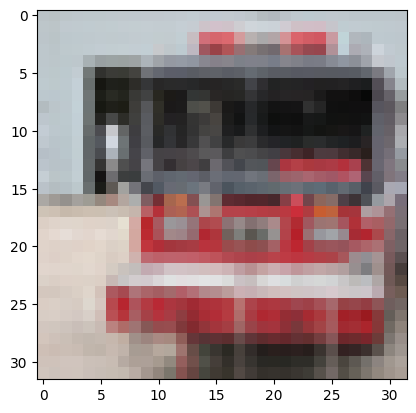

In [8]:
plt.imshow(x_train_scaled[random.choice(range(0,39999))],cmap=plt.cm.binary)

Al ser imágenes de 32x32, la calidad no es muy buena. Vamos a proyectar múltiples imágenes de menor tamaño con su correspondiente etiqueta.

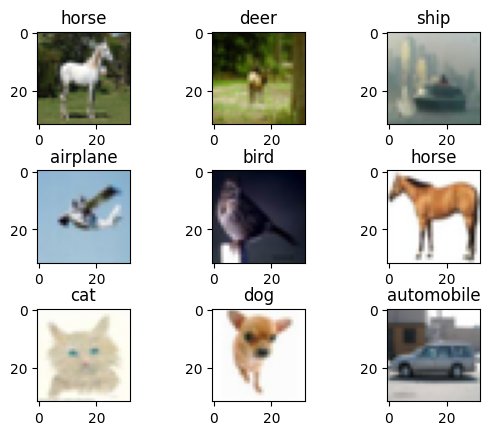

In [9]:
for i in range(9):
    j = random.randint(1,40000)
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train_scaled[j], cmap=plt.get_cmap('gray'))
    plt.title(cifar10_labels[y_train_label[j]])
plt.subplots_adjust(hspace = 0.5)
plt.show()

## Data augmentation

Llamamos *data augmentation* a la técnica de modificar las imágenes de entrenamiento de varias formas (rotaciones, zoom, deformaciones, colores, etc) para que el modelo entrene con una mayor variedad de datos y sea menos propenso a sobreajustarse.

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.4,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest'
    )

train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=50
)

In [11]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
    )
validation_generator = validation_datagen.flow(
    x_val,
    y_val,
    batch_size=20
)

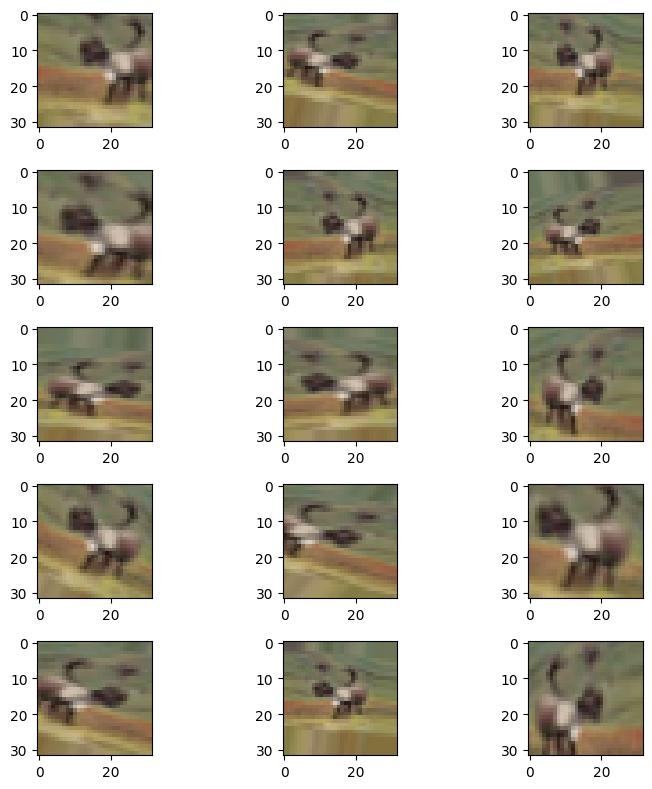

In [12]:
sample = random.choice(range(0,4999))

example_generator = train_datagen.flow(
    x_train[sample:sample+1],
    y_train[sample:sample+1],
    batch_size=1
)

plt.figure(figsize=(8, 8))
for i in range(0,15):
  plt.subplot(5, 3, i+1)
  for X,y in example_generator:
    image = X[0]
    plt.imshow(image)
    break
plt.tight_layout()
plt.show()

## Entrenamiento

Definimos el modelo. Consistirá en una red neuronal con varias capas de convolución y varios Dropouts.

In [13]:
model = ks.Sequential()

model.add(ks.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', input_shape=(32,32,3)))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same'))
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')) #64
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Flatten())
model.add(ks.layers.Dropout(0.15)) #0.2
model.add(ks.layers.Dense(32, activation='relu'))
model.add(ks.layers.Dropout(0.15)) #0.2
model.add(ks.layers.Dense(10, activation='softmax'))

c:\Users\diego\Documents\GitHub\CIFAR-10\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        65,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,146 (621.66 KB)

 Trainable params: 159,146 (621.66 KB)

 Non-trainable params: 0 (0.00 B)

Compilamos el modelo con el optimizador Adam y con la entropía como función de costes. Analizaremos la precisión del modelo pues estamos en un problema balanceado, y añadiremos dos callbacks para optimizar el tiempo de ejecución.

In [15]:
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callback_val_loss = EarlyStopping(monitor="val_loss", patience=10)
callback_val_accuracy = EarlyStopping(monitor="val_accuracy", patience=10)

Establecemos una variable temporal para controlar el tiempo de entrenamiento.

In [16]:
t = time.perf_counter()

Y entrenamos

In [17]:
history = model.fit(x_train_scaled, y_train, epochs=200,
                    batch_size= 512,
                    validation_data=(x_val_scaled, y_val),
                    callbacks=[callback_val_loss, callback_val_accuracy])

Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 295ms/step - accuracy: 0.1953 - loss: 2.1429 - val_accuracy: 0.3464 - val_loss: 1.8008
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.3384 - loss: 1.7786 - val_accuracy: 0.4267 - val_loss: 1.5759
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 284ms/step - accuracy: 0.4065 - loss: 1.6108 - val_accuracy: 0.4875 - val_loss: 1.4335
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 260ms/step - accuracy: 0.4491 - loss: 1.4967 - val_accuracy: 0.5238 - val_loss: 1.3402
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 226ms/step - accuracy: 0.4880 - loss: 1.4014 - val_accuracy: 0.5513 - val_loss: 1.2740
Epoch 6/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 230ms/step - accuracy: 0.5231 - loss: 1.3249 - val_accuracy: 0.5821 - val_loss: 1.1901
Epoch 7/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 216ms/step - accuracy: 0.5435 - loss: 1.2638 - val_accuracy: 0.6014 - val_loss: 1.1431
Epoch 8/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 236ms/step - accuracy: 0.5706 - loss: 1.1983 - 

In [18]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Tiempo de entrenamiento:', elapsed_time)

Tiempo de entrenamiento: 0:15:35.784299


Veamos la evolución de las métricas respecto a las fases

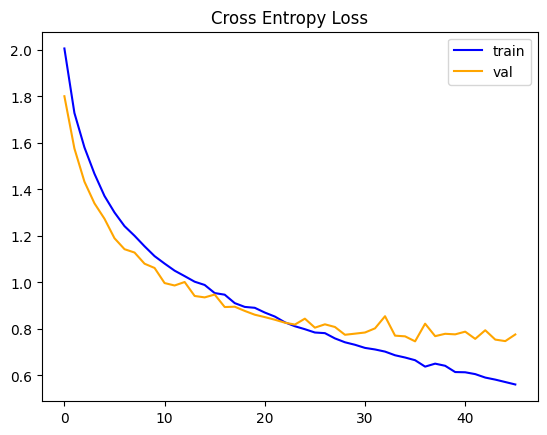

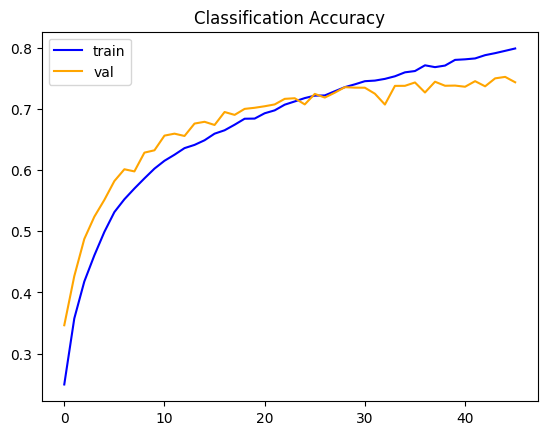

In [19]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='val')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='val')
plt.legend()
plt.show()

## Predicciones

Una vez definido y entrenado el modelo, podemos evaluar los datos de test.

In [20]:
_, acc = model.evaluate(x_test_scaled, y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

> 73.280


In [21]:
predictions = model.predict(x_test_scaled)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


Veamos varias imágenes y las predicciones de nuestro modelo. Para ello definimos las siguientes funciones auxiliares, para generar y mostrar las imágenes con las predicciones ilustradas en barras.

In [22]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'


def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'} 



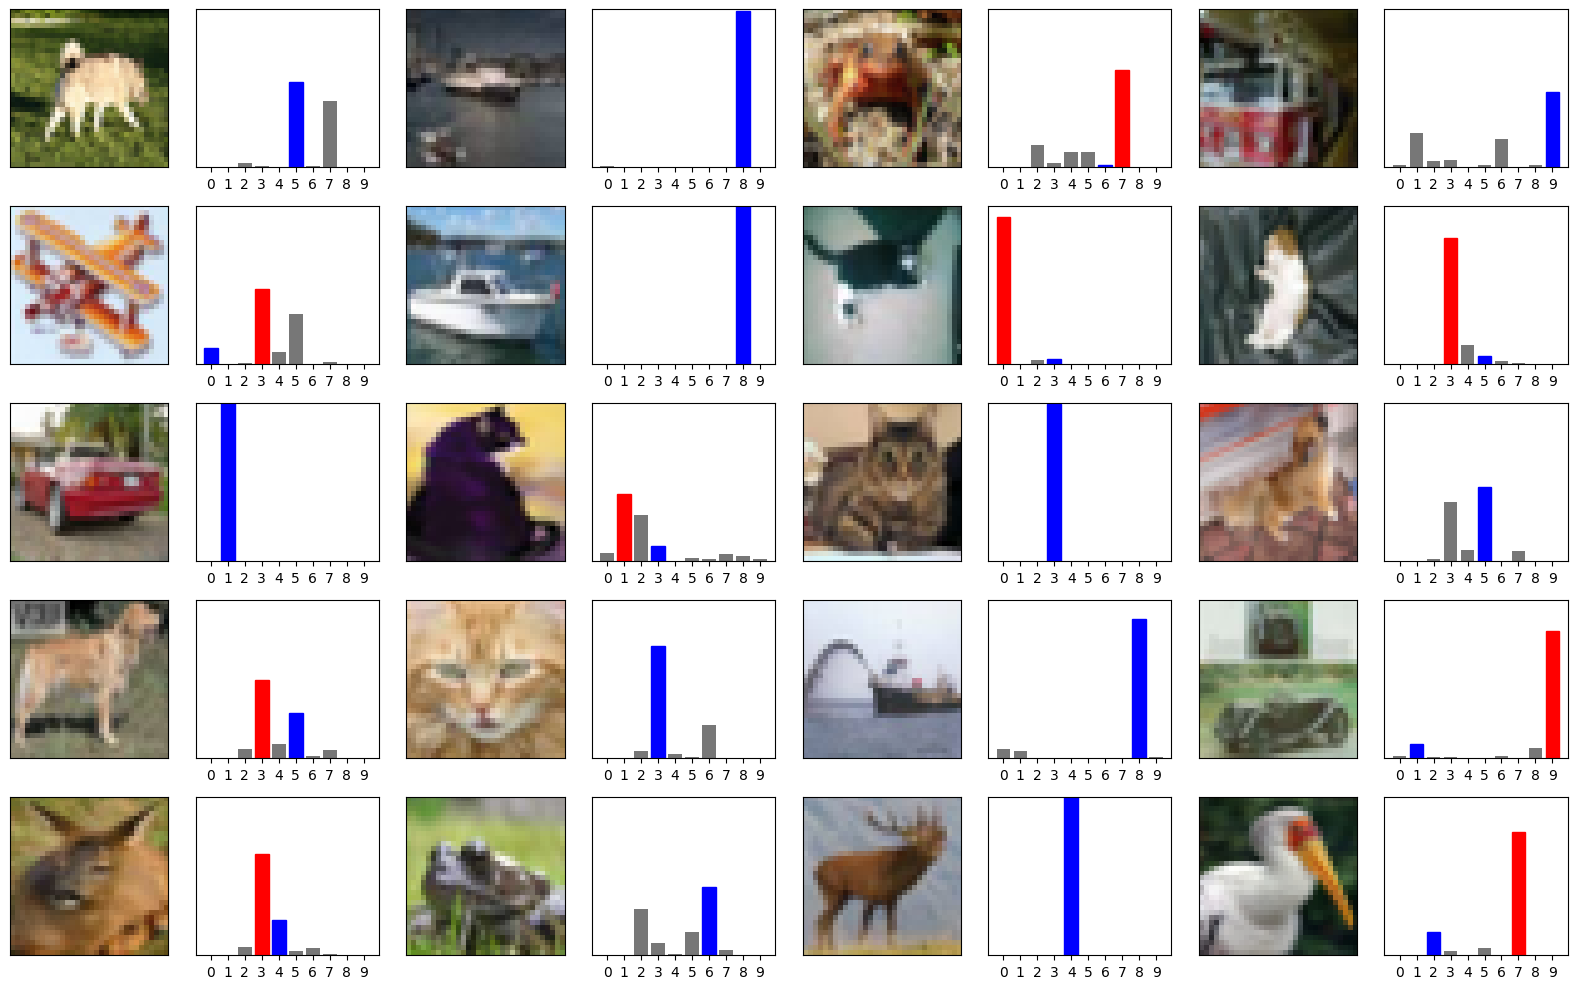


 {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [23]:
i = 0
cifar10_labels_dict={}
for l in cifar10_labels:
    cifar10_labels_dict[i]=l
    i += 1
print(cifar10_labels_dict,"\n")

num_rows = 5
num_cols = 4
start = random.randint(0,10000)
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+start, predictions[i+start], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()


print("\n",cifar10_labels_dict)